In [2]:
import os
import pandas as pd

%run ../scripts/gini
%run ../scripts/extract_wikipedia_misspellings

## Calculate Stats

In [2]:
path = "../outputs"
files = [file for file in os.listdir(path) if file.endswith(".tsv")]
len(files) # number of language wikis extracted

86

In [3]:
misspellings = load_exploded_misspellings("../resources/all_wiki_common_misspellings.tsv")
len(misspellings)

7566

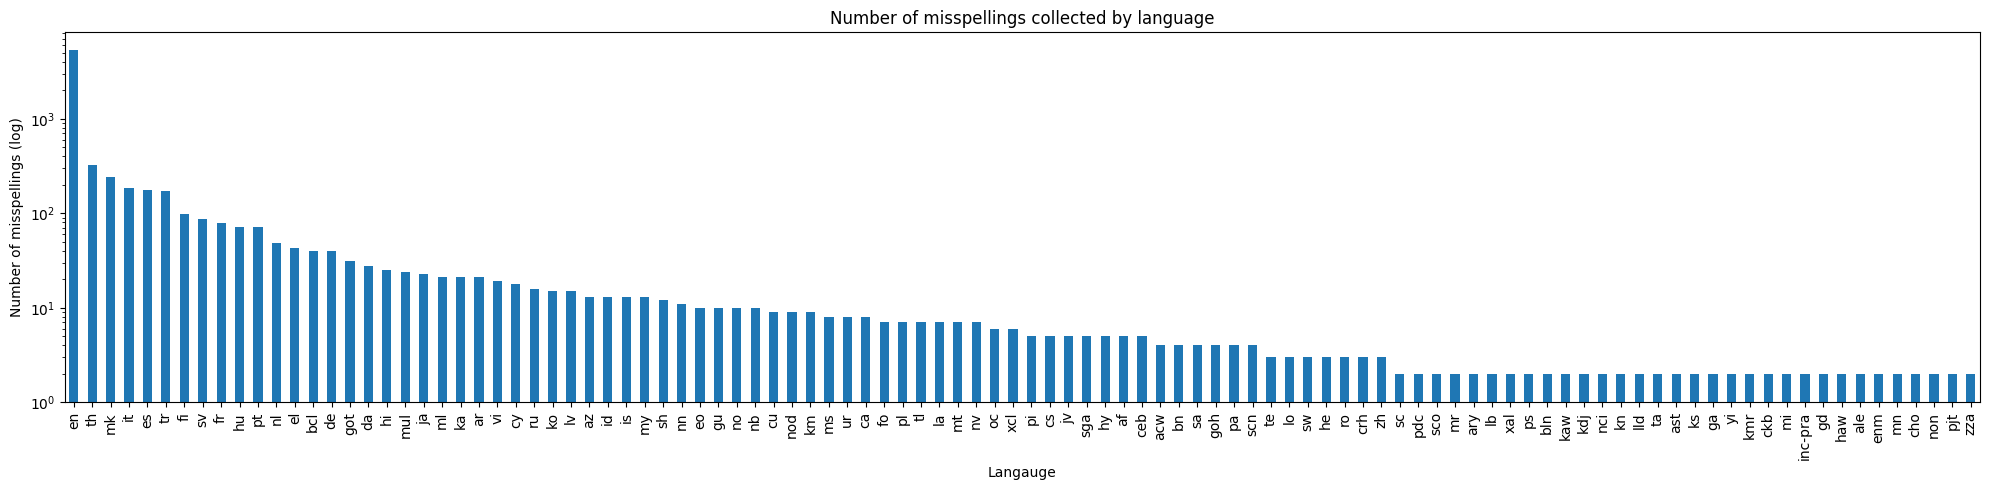

In [4]:
ax = misspellings["ln"].value_counts().plot(kind='bar', figsize=(20,5), log=True)
ax.set_xlabel("Langauge")
ax.set_ylabel("Number of misspellings (log)")
ax.set_title("Number of misspellings collected by language")
ax.figure.tight_layout()
ax.figure.savefig("../outputs/figures/misspelling_parsed_from_wiktionary_by_language.png")

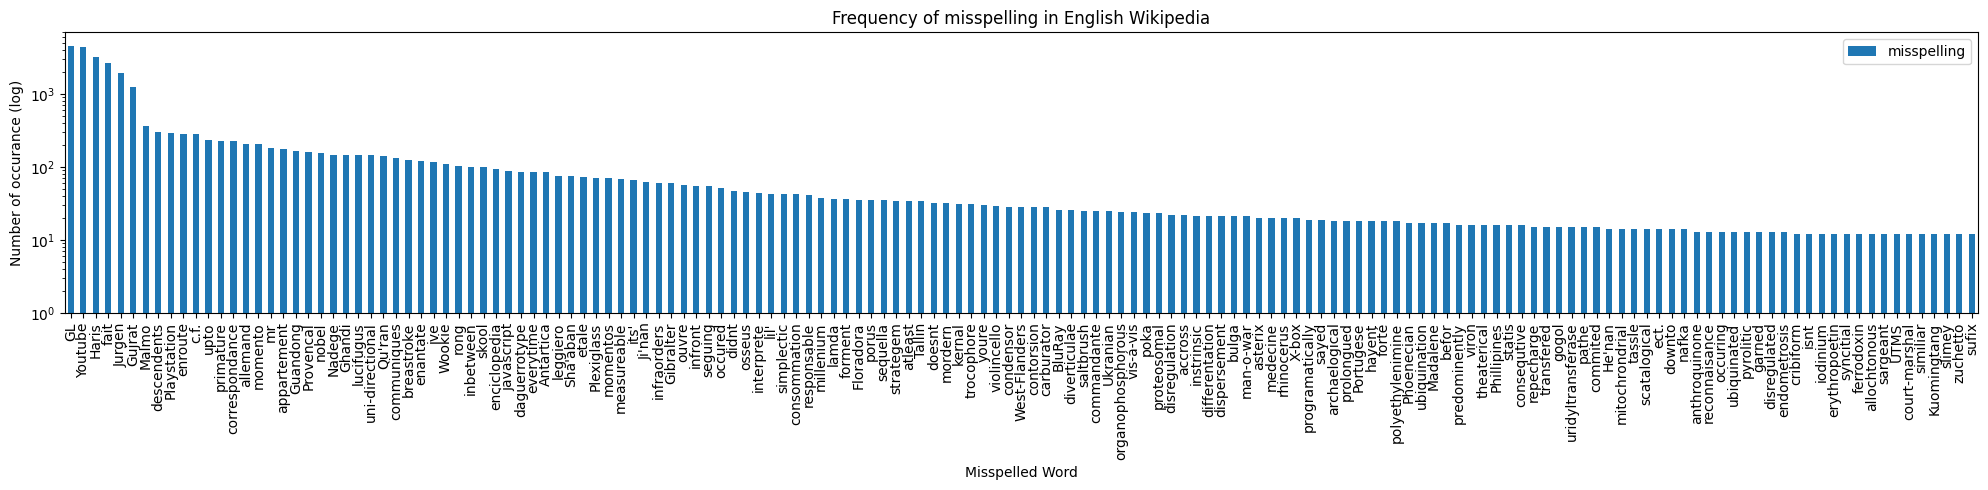

In [3]:
enwiki = pd.read_csv("../outputs/enwiki_detected_misspelling.tsv", delimiter="\t")

df = enwiki["misspelling"].value_counts().to_frame()

ax = df[df["misspelling"]>10].plot(kind='bar', figsize=(20,5), log=True)
ax.set_xlabel("Misspelled Word")
ax.set_ylabel("Number of occurance (log)")
ax.set_title("Frequency of misspelling in English Wikipedia")
ax.figure.tight_layout()
ax.figure.savefig("../outputs/figures/enwiki_misspelling_frequency.png")

In [4]:
def filter_formatting(df_formatting):
    """
    Given a list if formatting items `df_formatting`, which is a value of `formatting column`,
    checks if any of its values fall in the filtering criteria.
    """
    for formatting in ["is_list", "is_table", "is_quote", "is_text_formatting", "is_different_language"]:
        if formatting in df_formatting:
            return True

    return False

In [5]:
dict_vals = []

for file in files:
    # print()
    
    wiki = file.split("_")[0]
    language = "en" if wiki == "simplewiki" else wiki[:-4]
    
    unique_missp = None
    gini_coeff = None
    filtered_num_detected_missp = None
    filtered_unique_missp = None
    filtered_gini_coeff = None
    
    misspellings_count = len(misspellings[misspellings["ln"]==language])
    # print("Number of misspellings in {}: {}".format(wiki, misspellings_count))
    
    df = pd.read_csv(os.path.join(path,file), sep="\t")
    num_detected_missp = len(df)
    if len(df) > 0:
        # print("Number of detected misspelling in {}: {}".format(wiki, num_detected_missp))

        unique_missp = df["misspelling"].nunique()
        # print("Number of unique detected misspelling in {}: {}".format(wiki, unique_missp))

        gini_coeff = gini(df["misspelling"].value_counts().values.astype(float))
        # print("Gini Coefficient is", gini_coeff)

        ## With filters
        # print("AFTER FILTERING")
        df = df[~df["formatting"].apply(filter_formatting)]
        filtered_num_detected_missp = len(df)
        if len(df) > 0:    
            # print("Number of detected misspelling in {}: {}".format(wiki, filtered_num_detected_missp))

            filtered_unique_missp = df["misspelling"].nunique()
            # print("Number of unique detected misspelling in {}: {}".format(wiki, filtered_unique_missp))

            filtered_gini_coeff = gini(df["misspelling"].value_counts().values.astype(float))
            # print("Gini Coefficient is", filtered_gini_coeff)
            
    dict_vals.append({
        "wiki": wiki,
        "language": language,
        "num_extracted_misspelling": misspellings_count,
        "num_detected_misspelling": num_detected_missp,
        "num_unique_misspelling": unique_missp,
        "gini_coefficient": gini_coeff,
        "filtered_num_detected_misspelling": filtered_num_detected_missp,
        "filtered_num_unique_misspelling": filtered_unique_missp,
        "filtered_gini_coefficient": filtered_gini_coeff
    })

In [6]:
len(dict_vals)

86

In [7]:
df = pd.DataFrame(dict_vals)
df.to_csv("../outputs/analysis_outputs/all_language_detected_misspelling_stats_from_all_wiki.csv", index=False)

## Analysis

In [9]:
df = pd.read_csv("../outputs/analysis_outputs/all_language_detected_misspelling_stats_from_all_wiki.csv")
df

wiki language  num_extracted_misspelling  num_detected_misspelling  \
0    ptwiki       pt                         70                      1058   
1    frwiki       fr                         78                       625   
2    shwiki       sh                         11                        61   
3    plwiki       pl                          6                         5   
4   ckbwiki      ckb                          1                         1   
..      ...      ...                        ...                       ...   
81   kowiki       ko                         14                       200   
82   mnwiki       mn                          1                         1   
83   fowiki       fo                          6                        11   
84   eswiki       es                        175                     16533   
85   lowiki       lo                          2                         0   

    num_unique_misspelling  gini_coefficient  \
0                     30.0          0.845747   
1                     43.0          0.769712   
2                      7.0          0.435597   
3                      3.0          0.133333   
4                      1.0          0.000000   
..                     ...               ...   
81                     8.0          0.555000   
82                     1.0          0.000000   
83                     3.0          0.363636   
84                   120.0          0.920923   
85                     NaN               NaN   

    filtered_num_detected_misspelling  filtered_num_unique_misspelling  \
0                               589.0                             23.0   
1                               216.0                             36.0   
2                                45.0                              5.0   
3                                 0.0                              NaN   
4                                 1.0                              1.0   
..                                ...                              ...   
81                               85.0                              8.0   
82                                0.0                              NaN   
83                                2.0                              2.0   
84                             7404.0                            102.0   
85                                NaN                              NaN   

    filtered_gini_coefficient  
0                    0.772274  
1                    0.612912  
2                    0.355556  
3                         NaN  
4                    0.000000  
..                        ...  
81                   0.633824  
82                        NaN  
83                   0.000000  
84                   0.899689  
85                        NaN  

[86 rows x 9 columns]

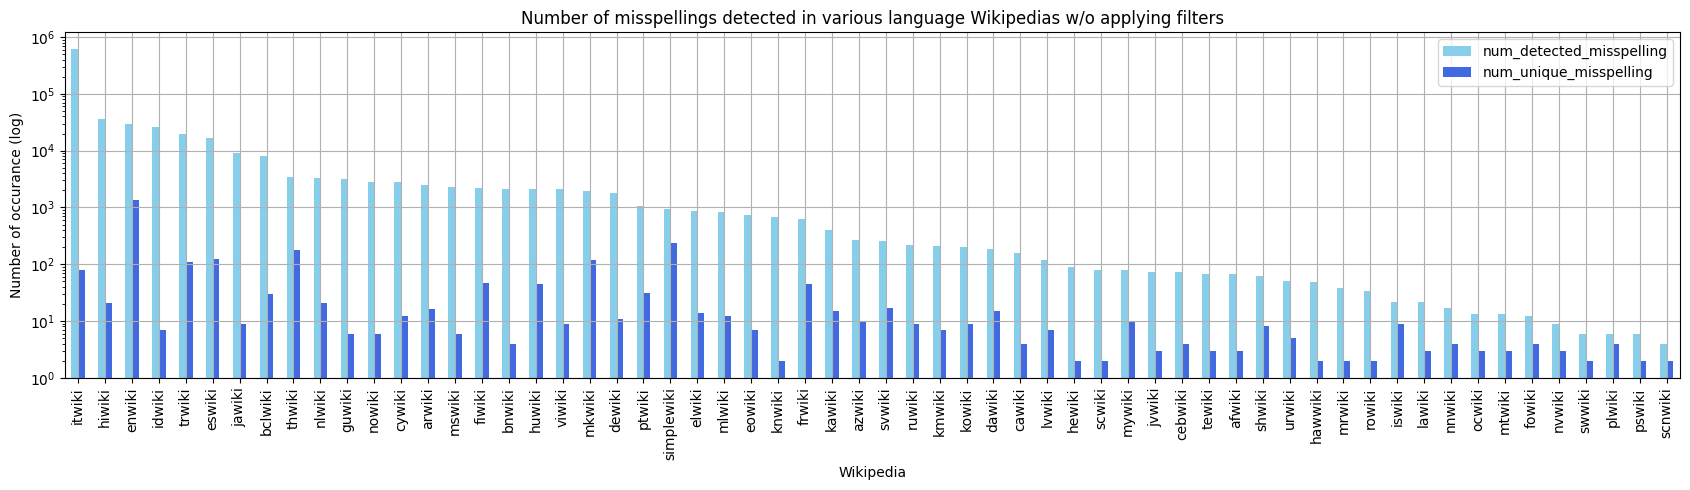

In [22]:
# which languages have the most misspellings (w/o filtering)
ax = df.sort_values("num_detected_misspelling", ascending=False).head(60)\
        .plot(x="wiki", 
              y=["num_detected_misspelling", "num_unique_misspelling"],
              kind="bar",
              figsize=(17,5),
              log=True,
              title="Number of misspellings detected in various language Wikipedias w/o applying filters",
              color=["skyblue", "royalblue"],
              grid=True
             )

ax.set_xlabel("Wikipedia")
ax.set_ylabel("Number of occurance (log)")
ax.figure.tight_layout()
ax.figure.savefig("../outputs/figures/all_wiki_misspelling_count.png")

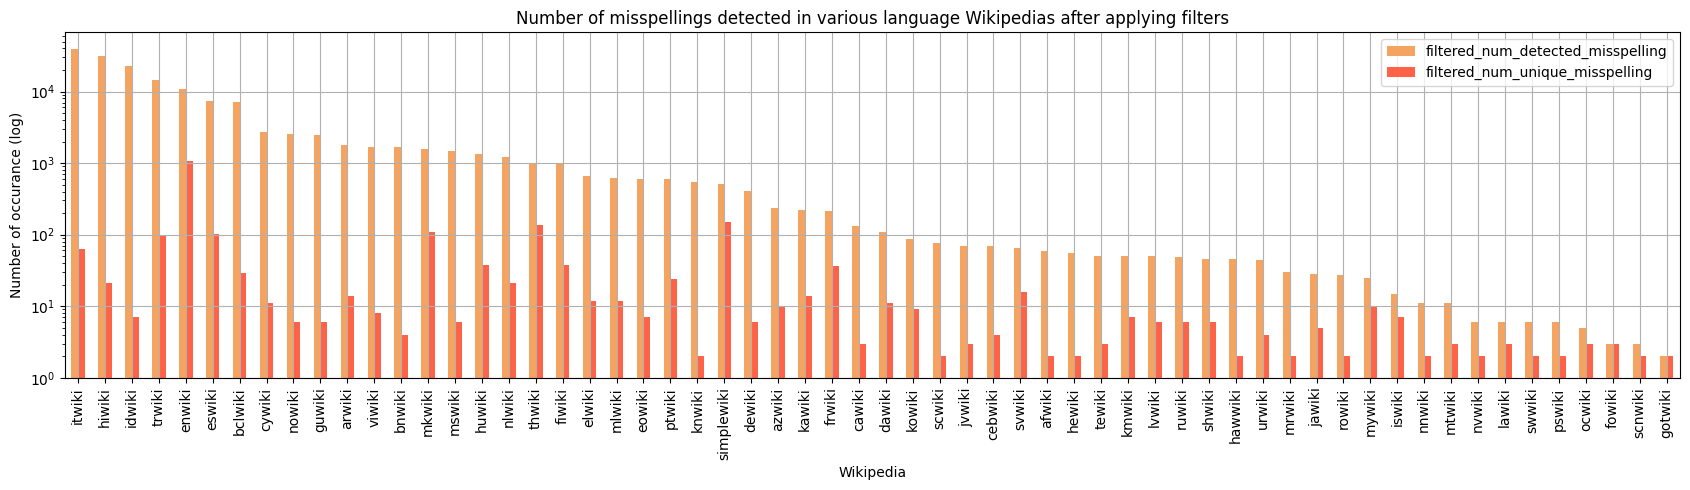

In [23]:
# which languages have the most misspellings w/ filtering
ax = df.sort_values("filtered_num_detected_misspelling", ascending=False).head(60)\
    .plot(x="wiki", 
          y=["filtered_num_detected_misspelling", "filtered_num_unique_misspelling"],
          kind="bar",
          figsize=(17,5),
          log=True,
          title="Number of misspellings detected in various language Wikipedias after applying filters",
          color=["sandybrown", "tomato"],
          grid=True
         )

ax.set_xlabel("Wikipedia")
ax.set_ylabel("Number of occurance (log)")
ax.figure.tight_layout()
ax.figure.savefig("../outputs/figures/all_wiki_misspelling_count_filtered.png")

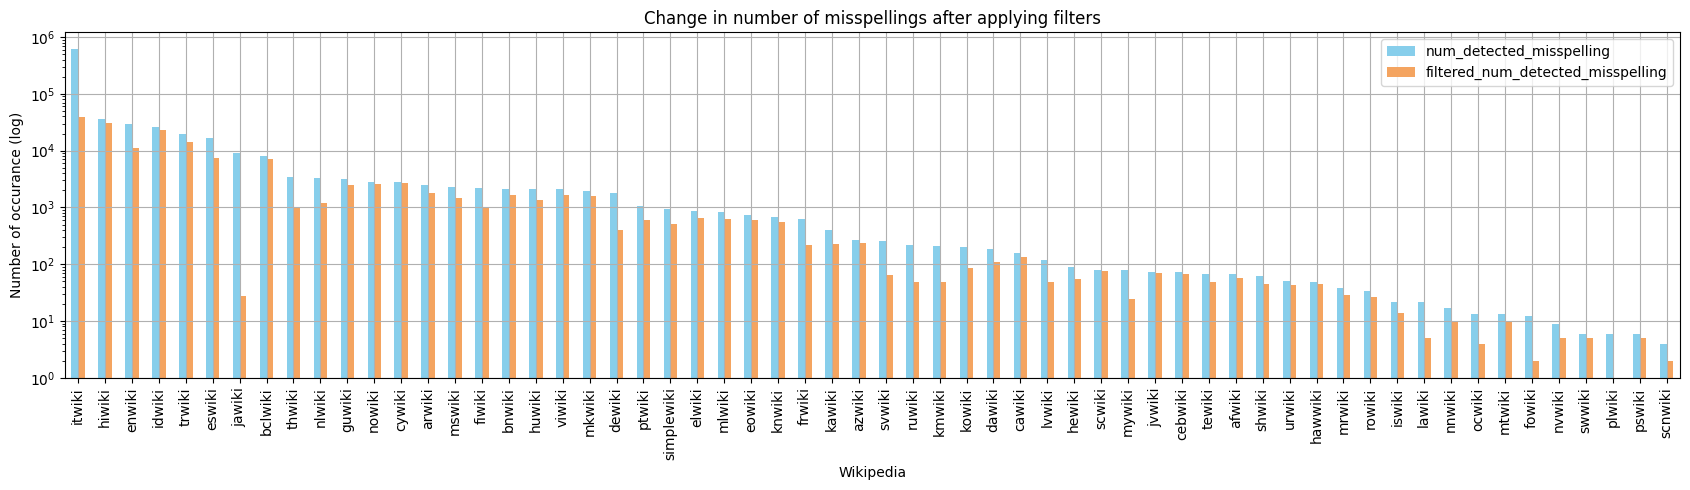

In [21]:
# How does filtering affect number of detected misspellings?
ax = df.sort_values("num_detected_misspelling", ascending=False).head(60)\
    .plot(x="wiki", 
          y=["num_detected_misspelling", "filtered_num_detected_misspelling"],
          kind="bar",
          figsize=(17,5),
          log=True,
          title="Change in number of misspellings after applying filters",
          color=["skyblue", "sandybrown"],
          grid=True
         )

ax.set_xlabel("Wikipedia")
ax.set_ylabel("Number of occurance (log)")
ax.figure.tight_layout()
ax.figure.savefig("../outputs/figures/all_wiki_misspelling_count_filtered_comparison.png")

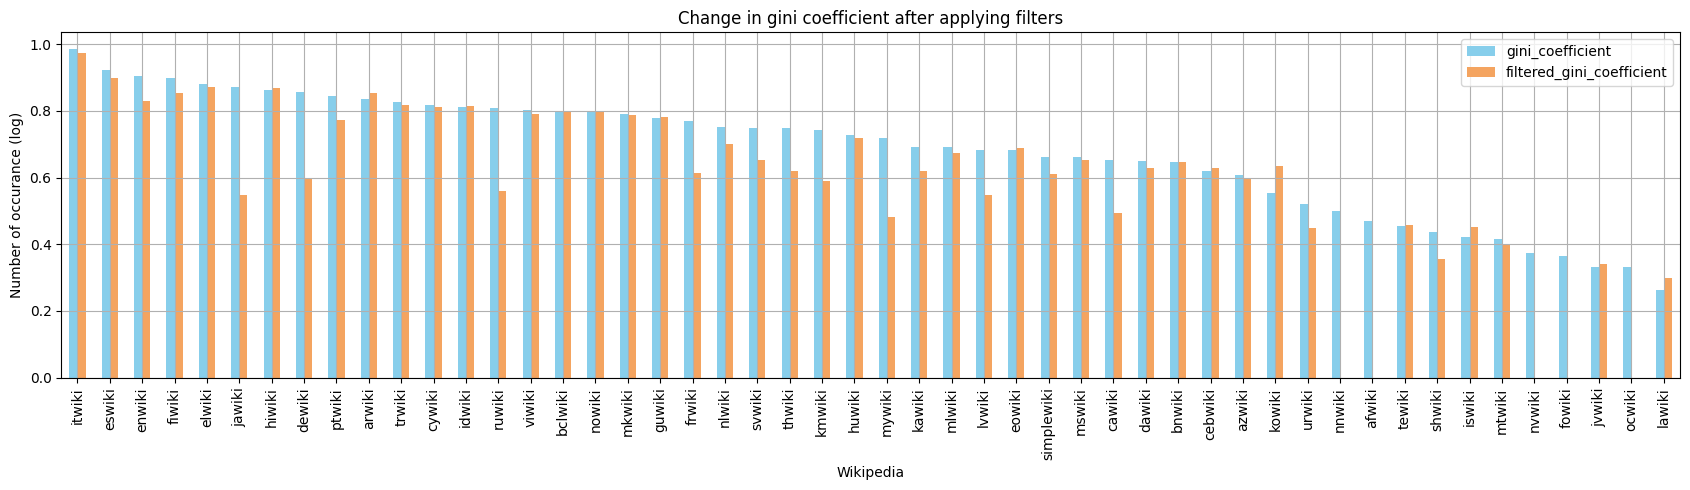

In [24]:
# How does filtering affect gini coefficient?
ax = df.sort_values("gini_coefficient", ascending=False).head(50)\
    .plot(x="wiki", 
          y=["gini_coefficient", "filtered_gini_coefficient"],
          kind="bar",
          figsize=(17,5),
          title="Change in gini coefficient after applying filters",
          color=["skyblue", "sandybrown"],
          grid=True
         )

ax.set_xlabel("Wikipedia")
ax.set_ylabel("Number of occurance (log)")
ax.figure.tight_layout()
ax.figure.savefig("../outputs/figures/all_wiki_misspelling_gini_filtered_comparison.png")